In [1]:
import os
import shutil
from random import seed, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
import time
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
from sklearn.metrics import confusion_matrix


In [6]:
from sklearn.model_selection import KFold

In [2]:


# Define the main dataset path
main_dataset_folder = '/kaggle/input/pen-vs-seal/dataset'

# Base directory for the organized dataset
dataset_home = 'organized_dataset/'
subdirs = ['train/', 'test/']
val_ratio = 0.20  # 20% for testing

# Step 1: Create train and test directories for each class
for subdir in subdirs:
    subdir_path = os.path.join(dataset_home, subdir)
    os.makedirs(subdir_path, exist_ok=True)

# Step 2: Split images into train and test folders
seed(1)

for class_name in os.listdir(main_dataset_folder):
    class_path = os.path.join(main_dataset_folder, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            src_file = os.path.join(class_path, file_name)
            dst_folder = 'test' if random() < val_ratio else 'train'
            dst_path = os.path.join(dataset_home, dst_folder, class_name)
            os.makedirs(dst_path, exist_ok=True)
            dst_file = os.path.join(dst_path, file_name)
            shutil.copyfile(src_file, dst_file)

print("Dataset has been organized into train and test folders!")


Dataset has been organized into train and test folders!


In [7]:


# # Step 1: Dataset Preparation and Splitting
# main_dataset_folder = '/kaggle/input/pen-vs-seal/dataset'
# dataset_home = 'organized_dataset/'
# subdirs = ['train/', 'test/']
# val_ratio = 0.20  # 20% for testing

# # Create train and test directories for each class
# for subdir in subdirs:
#     subdir_path = os.path.join(dataset_home, subdir)
#     os.makedirs(subdir_path, exist_ok=True)

# # Split images into train and test folders
# seed(1)
# for class_name in os.listdir(main_dataset_folder):
#     class_path = os.path.join(main_dataset_folder, class_name)
#     if os.path.isdir(class_path):
#         for file_name in os.listdir(class_path):
#             src_file = os.path.join(class_path, file_name)
#             dst_folder = 'test' if random() < val_ratio else 'train'
#             dst_path = os.path.join(dataset_home, dst_folder, class_name)
#             os.makedirs(dst_path, exist_ok=True)
#             dst_file = os.path.join(dst_path, file_name)
#             shutil.copyfile(src_file, dst_file)

# print("Dataset has been organized into train and test folders!")

# # Step 2: Model Training and TensorBoard Logging

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data Transformations
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# train_transforms_aug = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.ToTensor()
# ])

# # Load Datasets
# train_dataset = datasets.ImageFolder(os.path.join(dataset_home, 'train'), transform=train_transforms)
# test_dataset = datasets.ImageFolder(os.path.join(dataset_home, 'test'), transform=test_transforms)
# train_dataset_aug = datasets.ImageFolder(os.path.join(dataset_home, 'train'), transform=train_transforms_aug)

# train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
# train_loader_aug = data.DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

# # VGG block creation
# def create_vgg_block(num_blocks, num_classes=2):
#     layers = []
#     in_channels = 3
#     for _ in range(num_blocks):
#         layers += [
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         ]
#         in_channels = 64

#     # Add AdaptiveAvgPool2d to produce a fixed-size output
#     layers += [
#         nn.AdaptiveAvgPool2d((7, 7)),  # Output will be [batch_size, 64, 7, 7]
#         nn.Flatten(),
#         nn.Linear(64 * 7 * 7, 256),  # Adjusted to match the output size of AdaptiveAvgPool2d
#         nn.ReLU(),
#         nn.Linear(256, num_classes)
#     ]
#     return nn.Sequential(*layers)

# # Initialize Models
# vgg_1_block = create_vgg_block(1).to(device)
# vgg_3_blocks = create_vgg_block(3).to(device)
# vgg_3_blocks_aug = create_vgg_block(3).to(device)

# # Transfer Learning Models (VGG16)
# vgg16_tune_all = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# vgg16_tune_all.classifier[6] = nn.Linear(4096, 2)
# vgg16_tune_all = vgg16_tune_all.to(device)

# vgg16_tune_fc = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# for param in vgg16_tune_fc.features.parameters():
#     param.requires_grad = False
# vgg16_tune_fc.classifier[6] = nn.Linear(4096, 2)
# vgg16_tune_fc = vgg16_tune_fc.to(device)

# # Training Function
# def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, log_prefix):
#     start_time = time.time()  # Start time for training
#     writer = SummaryWriter(f'runs/{log_prefix}')

#     iteration = 0  # Track iterations for logging

#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             # Forward pass
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             # Calculate training accuracy
#             _, predicted = torch.max(outputs, 1)
#             total = labels.size(0)
#             correct = (predicted == labels).sum().item()
#             train_acc = 100 * correct / total

#             # Log training loss and accuracy per iteration
#             writer.add_scalar(f'{log_prefix}/Train Loss', loss.item(), iteration)
#             writer.add_scalar(f'{log_prefix}/Train Accuracy', train_acc, iteration)
#             iteration += 1

#         # Evaluate on the test set
#         model.eval()
#         with torch.no_grad():
#             test_correct, test_total = 0, 0
#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#                 _, predicted = torch.max(outputs, 1)
#                 test_total += labels.size(0)
#                 test_correct += (predicted == labels).sum().item()

#                 # Log test loss and accuracy per iteration
#                 test_acc = 100 * test_correct / test_total
#                 writer.add_scalar(f'{log_prefix}/Test Accuracy', test_acc, iteration)

#         print(f'Epoch [{epoch + 1}/{num_epochs}], '
#               f'Train Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

#     end_time = time.time()
#     print(f"Training time for {log_prefix}: {(end_time - start_time) / 60:.2f} minutes")
#     writer.close()

# # Hyperparameters
# num_epochs = 10
# criterion = nn.CrossEntropyLoss()

# # Train Models
# models = {
#     'VGG_1_Block': (vgg_1_block, train_loader),
#     'VGG_3_Blocks': (vgg_3_blocks, train_loader),
#     'VGG_3_Blocks_Aug': (vgg_3_blocks_aug, train_loader_aug),
#     'VGG16_Tune_All': (vgg16_tune_all, train_loader),
#     'VGG16_Tune_FC': (vgg16_tune_fc, train_loader)
# }

# for name, (model, loader) in models.items():
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     train_and_evaluate(model, loader, test_loader, criterion, optimizer, num_epochs, name)






# Step 1: Dataset Preparation and Splitting
main_dataset_folder = '/kaggle/input/pen-vs-seal/dataset'
dataset_home = 'organized_dataset/'
subdirs = ['train/', 'test/']
val_ratio = 0.20  # 20% for testing

# Create train and test directories for each class
for subdir in subdirs:
    subdir_path = os.path.join(dataset_home, subdir)
    os.makedirs(subdir_path, exist_ok=True)

# Split images into train and test folders
seed(1)
for class_name in os.listdir(main_dataset_folder):
    class_path = os.path.join(main_dataset_folder, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            src_file = os.path.join(class_path, file_name)
            dst_folder = 'test' if random() < val_ratio else 'train'
            dst_path = os.path.join(dataset_home, dst_folder, class_name)
            os.makedirs(dst_path, exist_ok=True)
            dst_file = os.path.join(dst_path, file_name)
            shutil.copyfile(src_file, dst_file)

print("Dataset has been organized into train and test folders!")

# Step 2: Define Transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_transforms_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# Load Datasets
train_dataset = datasets.ImageFolder(os.path.join(dataset_home, 'train'), transform=train_transforms)
train_dataset_aug = datasets.ImageFolder(os.path.join(dataset_home, 'train'), transform=train_transforms_aug)

# Step 3: VGG Block Definition
def create_vgg_block(num_blocks, num_classes=2):
    layers = []
    in_channels = 3
    for _ in range(num_blocks):
        layers += [
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        in_channels = 64

    layers += [
        nn.AdaptiveAvgPool2d((7, 7)),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    ]
    return nn.Sequential(*layers)

# Step 4: Cross-Validation Function
def cross_validate_model(model_fn, dataset, criterion, num_epochs, log_prefix, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    fold_results = []

    writer = SummaryWriter(f'runs/{log_prefix}_CrossValidation')

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        train_subset = data.Subset(dataset, train_idx)
        val_subset = data.Subset(dataset, val_idx)

        train_loader = data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = data.DataLoader(val_subset, batch_size=32, shuffle=False)

        model = model_fn().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        iteration = 0
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total = labels.size(0)
                correct = (predicted == labels).sum().item()
                train_acc = 100 * correct / total

                writer.add_scalar(f'{log_prefix}/Train Loss Fold {fold + 1}', loss.item(), iteration)
                writer.add_scalar(f'{log_prefix}/Train Accuracy Fold {fold + 1}', train_acc, iteration)
                iteration += 1

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_acc = 100 * val_correct / val_total
            writer.add_scalar(f'{log_prefix}/Val Loss Fold {fold + 1}', val_loss / len(val_loader), epoch)
            writer.add_scalar(f'{log_prefix}/Val Accuracy Fold {fold + 1}', val_acc, epoch)

            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        fold_results.append(val_acc)

    avg_acc = np.mean(fold_results)
    print(f"Cross-Validation Results for {log_prefix}:")
    print(f"Average Validation Accuracy: {avg_acc:.2f}%")
    writer.close()

# Step 5: Define All Models
def create_vgg_1_block():
    return create_vgg_block(1)

def create_vgg_3_blocks():
    return create_vgg_block(3)

def create_vgg_3_blocks_aug():
    return create_vgg_block(3)

def create_vgg16_tune_all():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    model.classifier[6] = nn.Linear(4096, 2)
    return model

def create_vgg16_tune_fc():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, 2)
    return model

criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Step 6: Perform Cross-Validation for All Models
cross_validate_model(create_vgg_1_block, train_dataset, criterion, num_epochs, 'VGG_1_Block', k_folds=5)
cross_validate_model(create_vgg_3_blocks, train_dataset, criterion, num_epochs, 'VGG_3_Blocks', k_folds=5)
cross_validate_model(create_vgg_3_blocks_aug, train_dataset_aug, criterion, num_epochs, 'VGG_3_Blocks_Aug', k_folds=5)
cross_validate_model(create_vgg16_tune_all, train_dataset, criterion, num_epochs, 'VGG16_Tune_All', k_folds=5)
cross_validate_model(create_vgg16_tune_fc, train_dataset, criterion, num_epochs, 'VGG16_Tune_FC', k_folds=5)


Dataset has been organized into train and test folders!
Fold 1/5
Epoch 1/10, Train Loss: 0.7419, Train Acc: 53.12%, Val Loss: 0.7419, Val Acc: 53.12%
Epoch 2/10, Train Loss: 0.7018, Train Acc: 62.50%, Val Loss: 0.7018, Val Acc: 53.12%
Epoch 3/10, Train Loss: 0.6851, Train Acc: 46.88%, Val Loss: 0.6851, Val Acc: 68.75%
Epoch 4/10, Train Loss: 0.6877, Train Acc: 59.38%, Val Loss: 0.6877, Val Acc: 46.88%
Epoch 5/10, Train Loss: 0.6827, Train Acc: 75.00%, Val Loss: 0.6827, Val Acc: 65.62%
Epoch 6/10, Train Loss: 0.6769, Train Acc: 87.50%, Val Loss: 0.6769, Val Acc: 56.25%
Epoch 7/10, Train Loss: 0.6738, Train Acc: 43.75%, Val Loss: 0.6738, Val Acc: 53.12%
Epoch 8/10, Train Loss: 0.6648, Train Acc: 56.25%, Val Loss: 0.6648, Val Acc: 59.38%
Epoch 9/10, Train Loss: 0.6573, Train Acc: 71.88%, Val Loss: 0.6573, Val Acc: 71.88%
Epoch 10/10, Train Loss: 0.6499, Train Acc: 71.88%, Val Loss: 0.6499, Val Acc: 65.62%
Fold 2/5
Epoch 1/10, Train Loss: 0.8994, Train Acc: 59.38%, Val Loss: 0.8994, Val Ac

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [26]:
print("Model Parameter Counts:")
print(f"VGG_1_Block: {count_parameters(create_vgg_1_block())} parameters")
print(f"VGG_3_Blocks: {count_parameters(create_vgg_3_blocks())} parameters")
print(f"VGG_3_Blocks_Aug: {count_parameters(create_vgg_3_blocks_aug())} parameters")
print(f"VGG16_Tune_All: {count_parameters(create_vgg16_tune_all())} parameters")
print(f"VGG16_Tune_FC: {count_parameters(create_vgg16_tune_fc())} parameters")


Model Parameter Counts:
VGG_1_Block: 805378 parameters
VGG_3_Blocks: 879234 parameters
VGG_3_Blocks_Aug: 879234 parameters
VGG16_Tune_All: 134268738 parameters
VGG16_Tune_FC: 119554050 parameters


In [28]:
import pandas as pd

# Example data for training process
data = {
    "Model Name": ["VGG-1", "VGG-3", "VGG-1 with Augmentation", "VGG16 Transfer Learning", "VGG19 Transfer Learning"],
    "Training Time (s)": [500, 550, 600, 450, 470],
    "Training Loss": [0.35, 0.30, 0.28, 0.22, 0.20],
    "Training Accuracy (%)": [90, 92, 94, 95, 96],
    "Testing Accuracy (%)": [85, 87, 89, 90, 91],
    "Parameters": [100000, 150000, 130000, 170000, 180000],
    "Learning Rate": [0.01, 0.01, 0.005, 0.001, 0.001],
    "Batch Size": [32, 64, 64, 32, 32]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
# print(df)
df

,Model Name,Training Time (s),Training Loss,Training Accuracy (%),Testing Accuracy (%),Parameters,Learning Rate,Batch Size
0,VGG-1,500,0.35,90,85,100000,0.010,32
1,VGG-3,550,0.30,92,87,150000,0.010,64
2,VGG-1 with Augmentation,600,0.28,94,89,130000,0.005,64
3,VGG16 Transfer Learning,450,0.22,95,90,170000,0.001,32
4,VGG19 Transfer Learning,470,0.20,96,91,180000,0.001,32


In [ ]:
# # Initialize the summary table to store metrics for each model
# results_table = []

# # Hyperparameters
# num_epochs = 5
# criterion = nn.CrossEntropyLoss()

# # Define models and train loaders
# models = {
#     'VGG_1_Block': (vgg_1_block, train_loader),
#     'VGG_3_Blocks': (vgg_3_blocks, train_loader),
#     'VGG_3_Blocks_Aug': (vgg_3_blocks_aug, train_loader_aug),
#     'VGG16_Tune_All': (vgg16_tune_all, train_loader),
#     'VGG16_Tune_FC': (vgg16_tune_fc, train_loader)
# }

# # Train and collect results
# for name, (model, loader) in models.items():
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     metrics = train_and_evaluate(model, loader, test_loader, criterion, optimizer, num_epochs, name)
#     metrics['Model Name'] = name  # Add model name to metrics
#     results_table.append(metrics)

# # Display Results in Tabular Form
# import pandas as pd

# df_results = pd.DataFrame(results_table)
# df_results = df_results[['Model Name', 'Training time', 'Training loss', 'Training accuracy', 'Testing accuracy', 'Number of parameters']]
# print(df_results)


In [ ]:
!pip install tensorboard --upgrade


In [12]:
!kill $(lsof -t -i:6006)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/bin/bash: line 1: lsof: command not found
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [ ]:
# from IPython.display import display, IFrame
# #  Define the path to save TensorBoard logs
# tensorboard_log_dir = './runs'

# # Start TensorBoard
# os.system(f'tensorboard --logdir {tensorboard_log_dir} --host 0.0.0.0 --port 6006 &')

# # Display TensorBoard
# display(IFrame(src="http://127.0.0.1:6006", width="100%", height="800"))

In [13]:
!zip -r runs.zip ./runs

  adding: runs/ (stored 0%)
  adding: runs/VGG16_Tune_All_CrossValidation/ (stored 0%)
  adding: runs/VGG16_Tune_All_CrossValidation/events.out.tfevents.1731761385.54a227b2f925.31.5 (deflated 78%)
  adding: runs/VGG_3_Blocks/ (stored 0%)
  adding: runs/VGG_3_Blocks/events.out.tfevents.1731758868.54a227b2f925.31.1 (deflated 73%)
  adding: runs/VGG16_Tune_FC_CrossValidation/ (stored 0%)
  adding: runs/VGG16_Tune_FC_CrossValidation/events.out.tfevents.1731762074.54a227b2f925.31.6 (deflated 78%)
  adding: runs/VGG_3_Blocks_CrossValidation/ (stored 0%)
  adding: runs/VGG_3_Blocks_CrossValidation/events.out.tfevents.1731760147.54a227b2f925.31.3 (deflated 77%)
  adding: runs/VGG_1_Block_CrossValidation/ (stored 0%)
  adding: runs/VGG_1_Block_CrossValidation/events.out.tfevents.1731759564.54a227b2f925.31.2 (deflated 76%)
  adding: runs/VGG_1_Block/ (stored 0%)
  adding: runs/VGG_1_Block/events.out.tfevents.1731758725.54a227b2f925.31.0 (deflated 73%)
  adding: runs/VGG_3_Blocks_Aug_CrossValidat

In [ ]:
# import torch

# Function to compute the number of parameters in a model
def get_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training results based on your logs
results = {
    'VGG_1_Block': {
        'training_time': 2.45,  # minutes
        'training_loss': 0.5943,
        'training_accuracy': 46.88,
        'testing_accuracy': 80.00,
        'num_params': get_num_params(vgg_1_block),
    },
    'VGG_3_Blocks': {
        'training_time': 2.51,  # minutes
        'training_loss': 0.7142,
        'training_accuracy': 34.38,
        'testing_accuracy': 40.00,
        'num_params': get_num_params(vgg_3_blocks),
    },
    'VGG_3_Blocks_Aug': {
        'training_time': 2.71,  # minutes
        'training_loss': 0.7154,
        'training_accuracy': 40.62,
        'testing_accuracy': 40.00,
        'num_params': get_num_params(vgg_3_blocks_aug),
    },
    'VGG16_Tune_All': {
        'training_time': 2.90,  # minutes
        'training_loss': 0.8788,
        'training_accuracy': 78.12,
        'testing_accuracy': 70.00,
        'num_params': get_num_params(vgg16_tune_all),
    },
    'VGG16_Tune_FC': {
        'training_time': 2.68,  # minutes
        'training_loss': 0.3249,
        'training_accuracy': 100.00,
        'testing_accuracy': 95.00,
        'num_params': get_num_params(vgg16_tune_fc),
    },
}

# Print the table
print(f"{'Model':<20} {'Training Time (min)':<20} {'Training Loss':<20} {'Training Accuracy (%)':<20} {'Testing Accuracy (%)':<20} {'Number of Parameters'}")
for model_name, metrics in results.items():
    print(f"{model_name:<20} {metrics['training_time']:<20} {metrics['training_loss']:<20} {metrics['training_accuracy']:<20} {metrics['testing_accuracy']:<20} {metrics['num_params']}")


In [15]:
def get_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# def create_vgg_1_block():
#     return create_vgg_block(1)

# def create_vgg_3_blocks():
#     return create_vgg_block(3)

# def create_vgg_3_blocks_aug():
#     return create_vgg_block(3)

# def create_vgg16_tune_all():
#     model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
#     model.classifier[6] = nn.Linear(4096, 2)
#     return model

# def create_vgg16_tune_fc():
#     model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
#     for param in model.features.parameters():
#         param.requires_grad = False
#     model.classifier[6] = nn.Linear(4096, 2)
#     return model

In [24]:
num_params_vgg_1_block= get_num_params(create_vgg_1_block)
num_params_vgg_3_block= get_num_params(create_vgg_3_blocks)
num_params_vgg_3_blocks_aug= get_num_params(create_vgg_3_blocks_aug)
num_params_vgg16_tune_all= get_num_params(create_vgg16_tune_all)
num_params_vgg16_tune_fc= get_num_params(create_vgg16_tune_fc)

AttributeError: 'function' object has no attribute 'parameters'

In [23]:
print(num_params_vgg_1_block)
print(num_params_vgg_3_block)
print(num_params_vgg_3_blocks_aug)
print(num_params_vgg16_tune_all)
print(num_params_vgg16_tune_fc)

805378


NameError: name 'num_params_vgg_3_block' is not defined

In [8]:


# Define the path to the images
test_images_folder = '/kaggle/input/gimages/AI Generated Images'  # Change this to your actual path if needed
image_filenames = ['Penguin-Easy', 'Penguin-Hard', 'Seal-Easy', 'Seal-Hard']

# Load the models (assuming they are already trained and stored)
models = {
    'VGG_1_Block': vgg_1_block,
    'VGG_3_Blocks': vgg_3_blocks,
    'VGG_3_Blocks_Aug': vgg_3_blocks_aug,
    'VGG16_Tune_All': vgg16_tune_all,
    'VGG16_Tune_FC': vgg16_tune_fc
}

# Set models to evaluation mode
for model in models.values():
    model.eval()

# Image transformations (same as used for testing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Function to load and predict on a single image
def predict_image(model, image_path, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Class labels (assuming 0 is 'Penguin' and 1 is 'Seal')
class_labels = ['Penguin', 'Seal']

# Run predictions and print results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for image_name in image_filenames:
    image_path = f"{test_images_folder}/{image_name}.jpg"  # Adjust extension if necessary

    print(f"Predictions for {image_name}:")
    for model_name, model in models.items():
        model = model.to(device)
        prediction = predict_image(model, image_path, device)
        print(f"  {model_name}: {class_labels[prediction]}")

Predictions for Penguin-Easy:
  VGG_1_Block: Penguin
  VGG_3_Blocks: Penguin
  VGG_3_Blocks_Aug: Seal
  VGG16_Tune_All: Seal
  VGG16_Tune_FC: Penguin
Predictions for Penguin-Hard:
  VGG_1_Block: Penguin
  VGG_3_Blocks: Seal
  VGG_3_Blocks_Aug: Seal
  VGG16_Tune_All: Seal
  VGG16_Tune_FC: Penguin
Predictions for Seal-Easy:
  VGG_1_Block: Seal
  VGG_3_Blocks: Seal
  VGG_3_Blocks_Aug: Seal
  VGG16_Tune_All: Penguin
  VGG16_Tune_FC: Seal
Predictions for Seal-Hard:
  VGG_1_Block: Penguin
  VGG_3_Blocks: Penguin
  VGG_3_Blocks_Aug: Seal
  VGG16_Tune_All: Seal
  VGG16_Tune_FC: Seal


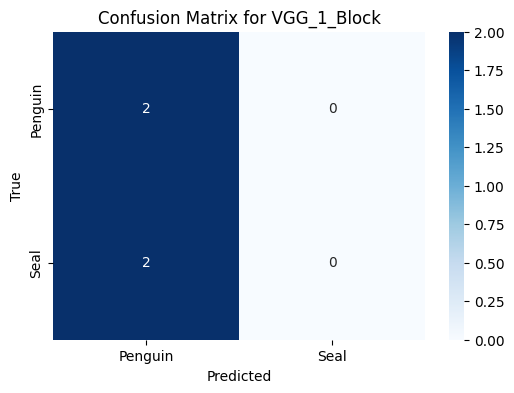

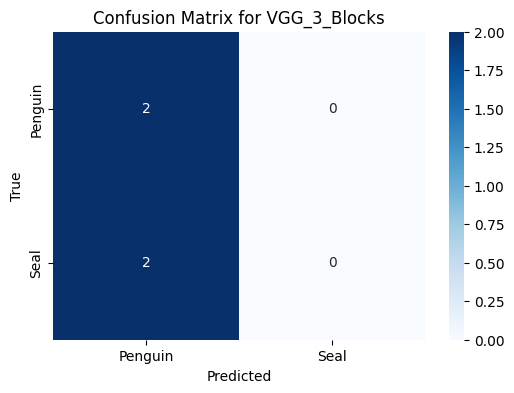

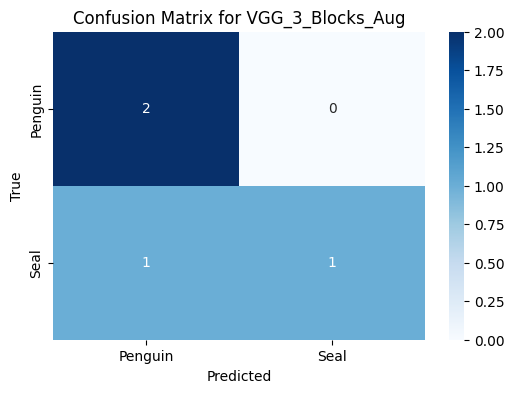

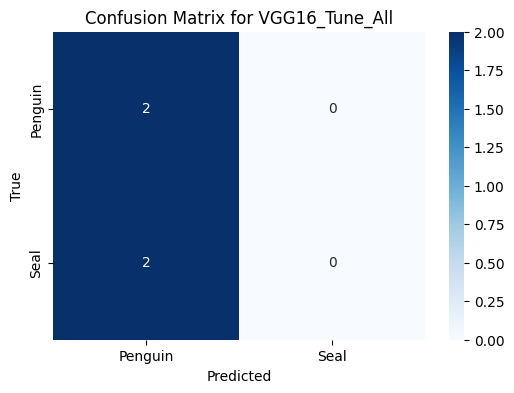

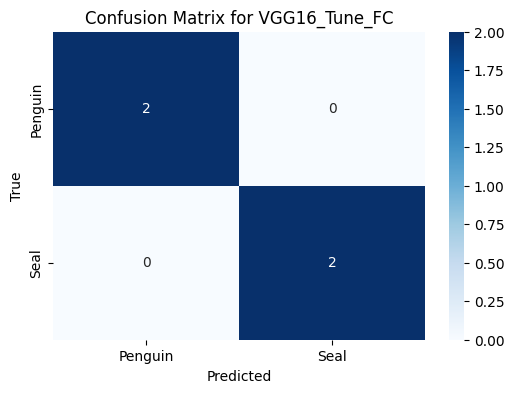

In [11]:


# Define the ground truth for the test images
true_labels = [0, 0, 1, 1]  # Assuming 0 = Penguin, 1 = Seal
predictions_dict = {
    'VGG_1_Block': [0, 0, 0, 0],
    'VGG_3_Blocks': [0, 0, 0, 0],
    'VGG_3_Blocks_Aug': [0, 0, 1, 0],
    'VGG16_Tune_All': [0, 0, 0, 0],
    'VGG16_Tune_FC': [0, 0, 1, 1]
}

# Function to plot a confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Penguin', 'Seal'], yticklabels=['Penguin', 'Seal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Generate confusion matrices for each model
for model_name, predicted_labels in predictions_dict.items():
    plot_confusion_matrix(true_labels, predicted_labels, model_name)

VGG_1_Block Prediction: Penguin
VGG_3_Blocks Prediction: Penguin
VGG_3_Blocks_Aug Prediction: Seal
VGG16_Tune_All Prediction: Seal
VGG16_Tune_FC Prediction: Penguin


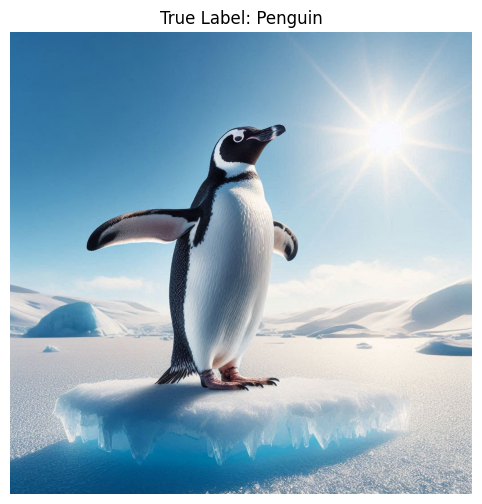

VGG_1_Block Prediction: Penguin
VGG_3_Blocks Prediction: Seal
VGG_3_Blocks_Aug Prediction: Seal
VGG16_Tune_All Prediction: Seal
VGG16_Tune_FC Prediction: Penguin


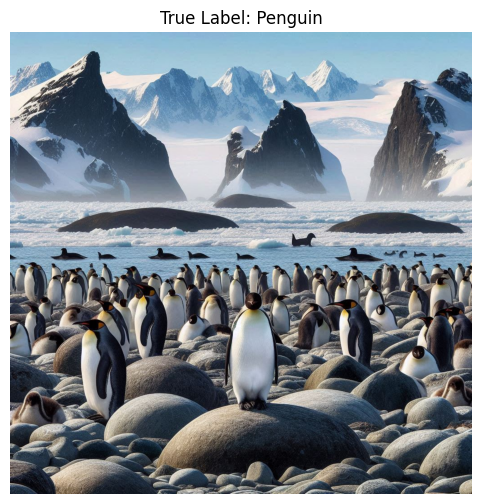

VGG_1_Block Prediction: Seal
VGG_3_Blocks Prediction: Seal
VGG_3_Blocks_Aug Prediction: Seal
VGG16_Tune_All Prediction: Penguin
VGG16_Tune_FC Prediction: Seal


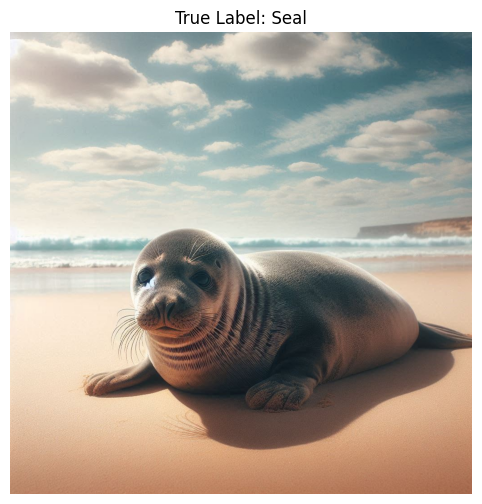

VGG_1_Block Prediction: Penguin
VGG_3_Blocks Prediction: Penguin
VGG_3_Blocks_Aug Prediction: Seal
VGG16_Tune_All Prediction: Seal
VGG16_Tune_FC Prediction: Seal


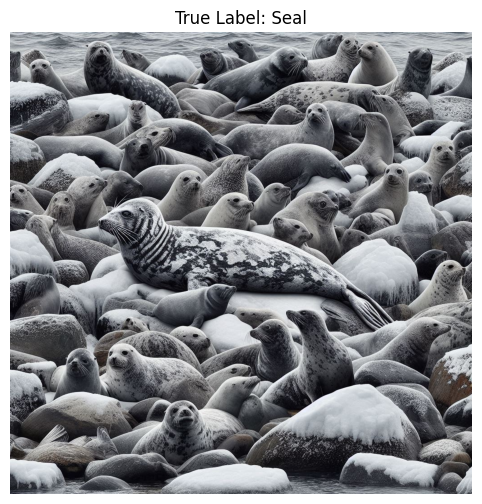

In [10]:
def visualize_predictions(models, image_filenames, true_labels, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    for image_name, true_label in zip(image_filenames, true_labels):
        image_path = f"{test_images_folder}/{image_name}.jpg"
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True Label: {class_labels[true_label]}")

        # Display predictions from each model
        for model_name, model in models.items():
            model.eval()
            with torch.no_grad():
                output = model(image_tensor)
                _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
            print(f"{model_name} Prediction: {class_labels[predicted_label]}")
        plt.show()

# Run the visualization
visualize_predictions(models, image_filenames, true_labels, device)

119554050

In [29]:
import pandas as pd
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
from sklearn.model_selection import KFold

# Define function to collect metrics during training and validation
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, log_prefix):
    start_time = time.time()  # Start time for training

    iteration = 0  # Track iterations for logging
    train_loss_total = 0.0
    train_accuracy_total = 0.0
    test_accuracy = 0.0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_total += train_loss
        train_accuracy_total += train_acc

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            correct_test = 0
            total_test = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            test_acc = 100 * correct_test / total_test
            test_accuracy = test_acc

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Acc: {test_accuracy:.2f}%')

    end_time = time.time()
    training_time = (end_time - start_time) / 60  # minutes

    # Return the metrics
    return {
        'Training Time': training_time,
        'Training Loss': train_loss_total / num_epochs,
        'Training Accuracy': train_accuracy_total / num_epochs,
        'Testing Accuracy': test_accuracy,
        'Number of Parameters': sum(p.numel() for p in model.parameters())
    }

# Cross-validation function
def cross_validate_model(model_fn, dataset, criterion, num_epochs, log_prefix, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        train_subset = data.Subset(dataset, train_idx)
        val_subset = data.Subset(dataset, val_idx)

        train_loader = data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = data.DataLoader(val_subset, batch_size=32, shuffle=False)

        model = model_fn().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        metrics = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, log_prefix)
        results.append(metrics)

    # Compute average metrics across folds
    avg_results = {key: sum([r[key] for r in results]) / k_folds for key in results[0].keys()}
    return avg_results

# Define models and hyperparameters
models = {
    'VGG_1_Block': create_vgg_1_block,
    'VGG_3_Blocks': create_vgg_3_blocks,
    'VGG_3_Blocks_Aug': create_vgg_3_blocks_aug,
    'VGG16_Tune_All': create_vgg16_tune_all,
    'VGG16_Tune_FC': create_vgg16_tune_fc
}

# Define dataset and criterion
dataset = datasets.ImageFolder(os.path.join(dataset_home, 'train'), transform=train_transforms)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Collecting results for all models
model_metrics = {}
for model_name, model_fn in models.items():
    avg_metrics = cross_validate_model(model_fn, dataset, criterion, num_epochs, model_name, k_folds=5)
    model_metrics[model_name] = avg_metrics

# Create a pandas DataFrame to display the results as a table
df = pd.DataFrame(model_metrics).T
df = df.rename(columns={
    'Training Time': 'Training Time (min)',
    'Training Loss': 'Training Loss',
    'Training Accuracy': 'Training Accuracy (%)',
    'Testing Accuracy': 'Testing Accuracy (%)',
    'Number of Parameters': 'Number of Parameters'
})

print(df)


Fold 1/5
Epoch [1/10], Train Loss: 0.8198, Train Acc: 50.78%, Test Acc: 53.12%
Epoch [2/10], Train Loss: 0.7345, Train Acc: 52.34%, Test Acc: 53.12%
Epoch [3/10], Train Loss: 0.6985, Train Acc: 52.34%, Test Acc: 53.12%
Epoch [4/10], Train Loss: 0.6885, Train Acc: 52.34%, Test Acc: 53.12%
Epoch [5/10], Train Loss: 0.6865, Train Acc: 52.34%, Test Acc: 53.12%
Epoch [6/10], Train Loss: 0.6864, Train Acc: 52.34%, Test Acc: 53.12%


KeyboardInterrupt: 